# Process results

Loads a CSV with benchmark data and plots a scatter chart based on analysis median time.

In [14]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

TIME_COLUMN = "Execution time series"
def read_dataset(filename):
    df = pd.read_csv(filename, index_col=0)
    for column in ["Stars", "Size", "Mentionable Users", "Commits"]:
        df[column] = df[column].astype('int')

    df = df.drop_duplicates(subset=['Repository'])
    df = df.query('Commits >= 100 & Language != None')
    # Repos less or equal 10Gb size
    df = df.query('Size <= 10000000')
    df = df[df[TIME_COLUMN] != "0.0"]
    
    df[TIME_COLUMN] = df[TIME_COLUMN].astype('object')
    df["Bus Factor"] = df["Bus Factor"].astype('int')
    return df

df = read_dataset("data/result.csv")
df.describe()

,Stars,Size,Mentionable Users,Commits,Bus Factor
count,943.000000,9.430000e+02,943.000000,943.000000,943.000000
mean,29453.748674,2.209381e+05,513.545069,1638.586426,2.427359
std,26277.948371,5.181760e+05,885.477256,2396.988686,2.518040
min,8925.000000,5.170000e+02,1.000000,100.000000,1.000000
25%,16191.500000,1.898350e+04,126.000000,279.500000,1.000000
50%,21468.000000,6.143600e+04,255.000000,737.000000,2.000000
75%,32708.500000,1.981075e+05,536.500000,1963.000000,3.000000
max,367200.000000,6.060546e+06,10000.000000,19165.000000,32.000000


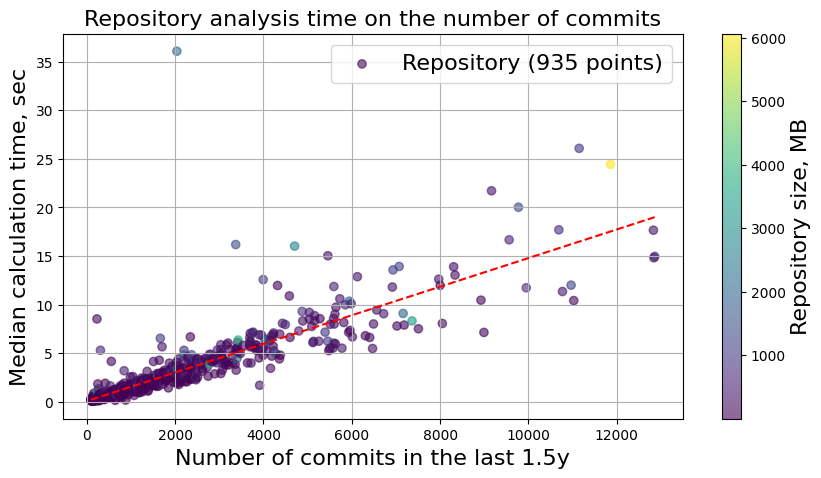

,Stars,Size,Mentionable Users,Commits,Bus Factor,Time_median,Size_in_Mb
count,935.000000,9.350000e+02,935.000000,935.000000,935.000000,935.000000,935.000000
mean,29244.194652,2.091213e+05,503.823529,1515.039572,2.365775,2.319209,209.121309
std,26044.517311,4.881768e+05,878.878253,1990.248059,2.251077,3.339065,488.176790
min,8925.000000,5.170000e+02,1.000000,100.000000,1.000000,0.081500,0.517000
25%,16167.000000,1.851600e+04,125.000000,278.000000,1.000000,0.396000,18.516000
50%,21459.000000,6.081000e+04,254.000000,727.000000,2.000000,1.016500,60.810000
75%,32432.500000,1.855765e+05,526.500000,1893.500000,3.000000,2.767000,185.576500
max,367200.000000,6.060546e+06,10000.000000,12858.000000,20.000000,36.068000,6060.546000


In [12]:
from scipy.optimize import curve_fit
import json
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test = df

# too few points with more than 13000 commits
test = test[test.Commits <= 13000]

test['Time_median'] = test[TIME_COLUMN].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
test['Time_median'] = test['Time_median'].apply(lambda x: statistics.median(x) / 1000)

def objective(x, a, b):
     return a * x + b

FONT_SIZE = 16
    
for category in ['Commits']:
    test.sort_values(by=[category], inplace=True)

    x = test[category].tolist()
    y = test['Time_median'].tolist()
    test['Size_in_Mb'] = test['Size'].apply(lambda x: x * 0.001)
    size = test['Size_in_Mb'].values

    fig, ax = plt.subplots(figsize=(10, 5))
    scatter = ax.scatter(x, y, c=size, label=f'Repository ({len(test)} points)', alpha=0.6)
    #ax = test.plot(x=category, y='Time_median', ylabel="Median calculation time, sec", legend=True, grid=True, figsize=(10,5), kind='scatter')

    # Create a fitting curve
    popt, _ = curve_fit(objective, x, y)
    # summarize the parameter values
    a, b = popt
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 1)
    # calculate the output for the range
    y_line = objective(x_line, a, b)
    # create a line plot for the mapping function
    ax.plot(x_line, y_line, '--', color='red')#, label = 'y = %.5f * x + %.3f' % (a, b))

    plt.title("Repository analysis time on the number of commits")
    plt.xlabel("Number of commits in the last 1.5y")
    plt.ylabel("Median calculation time, sec")
    ax.legend(fontsize=FONT_SIZE)
    ax.grid(True)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Repository size, MB', fontsize=FONT_SIZE)
    #plt.rc('axes', titlesize=16)     # fontsize of the axes title
    #plt.rc('legend', titlesize=16)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(FONT_SIZE)

    plt.savefig("chart.pdf", format="pdf", bbox_inches="tight")
    plt.show()
        
test.describe()
    

In [13]:
stats = (
    test[["Language", "Time_median", "Size_in_Mb", "Stars", "Mentionable Users", "Commits"]]
    .groupby(["Language"])
    .agg(["mean", "count", "sum", "median"])
)

stats.columns = stats.columns.map("_".join)
stats = stats.rename(columns={"Size_in_Mb_count": "Repositories", "Stars_sum": "Stars\n(total)", "Commits_sum": "Commits\n(total)", "Commits_median": "Commits\n(median)", "Size_in_Mb_median": "Size\n(median, MB)", "Time_median_median": "Time\n(median, sec)"})

stats = stats[['Repositories', "Commits\n(total)", "Commits\n(median)", "Size\n(median, MB)", "Time\n(median, sec)"]]

stats["Commits\n(total)"] = stats["Commits\n(total)"].apply(lambda x: format(x, ','))
stats["Time\n(median, sec)"] = stats["Time\n(median, sec)"].apply(lambda x: '%.3f' % (x)) 
stats["Size\n(median, MB)"] = stats["Size\n(median, MB)"].apply(lambda x: '%.1f' % (x)) 

stats["Commits\n(median)"] = stats["Commits\n(median)"].apply(lambda x: str(int(x)))

stats.sort_values(by=["Repositories"], ascending=False, inplace=True)

stats.head(5)

,Repositories,Commits\n(total),Commits\n(median),"Size\n(median, MB)","Time\n(median, sec)"
Language,,,,,
TypeScript,166,"298,072",983,74.5,1.375
JavaScript,137,"139,521",394,43.5,0.512
Python,128,"182,847",719,41.5,0.994
Go,110,"150,623",725,33.0,0.921
C++,68,"119,267",780,74.2,1.137


In [10]:
print(
    stats.head(5)\
      .to_latex(bold_rows=True, caption="Top 10 language groups in dataset", label="table:dataset")
)

\begin{table}
\caption{Top 10 language groups in dataset}
\label{table:dataset}
\begin{tabular}{lrllll}
\toprule
 & Repositories & Commits
(total) & Commits
(median) & Size
(median, MB) & Time
(median, sec) \\
Language &  &  &  &  &  \\
\midrule
\textbf{TypeScript} & 166 & 298,072 & 983 & 74.5 & 1.375 \\
\textbf{JavaScript} & 137 & 139,521 & 394 & 43.5 & 0.512 \\
\textbf{Python} & 128 & 182,847 & 719 & 41.5 & 0.994 \\
\textbf{Go} & 110 & 150,623 & 725 & 33.0 & 0.921 \\
\textbf{C++} & 68 & 119,267 & 780 & 74.2 & 1.137 \\
\bottomrule
\end{tabular}
\end{table}



In [11]:
test[["Size_in_Mb", "Stars", "Mentionable Users", "Commits", "Time_median"]].agg(["mean", "count", "sum", "median"])

,Size_in_Mb,Stars,Mentionable Users,Commits,Time_median
mean,209.121309,2.924419e+04,503.823529,1.515040e+03,2.319209
count,935.000000,9.350000e+02,935.000000,9.350000e+02,935.000000
sum,195528.424000,2.734332e+07,471075.000000,1.416562e+06,2168.460000
median,60.810000,2.145900e+04,254.000000,7.270000e+02,1.016500
